
# FIN 512 Snowball Case
## Team Member:  Zehua Li,   Meihua Xie,   Zishan Cai
## netID: zehuali2,  mxie6,  zcai10

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.optimize import minimize

## Loading data

In [2]:
erb = pd.read_excel("EUR3MTD156N.xls", header = None)
zcb = pd.read_excel("Eurozone_zero_coupon_yield_curves.xlsx", header = 1)

In [3]:
erb['date']=erb[0].astype('str')

In [4]:
ntn = 89083545 # notional

## Spread dates

In [5]:
ind = erb[((erb['date'].str[5:]=='03-13') | 
          (erb['date'].str[5:]=='06-13') |
          (erb['date'].str[5:]=='09-13') |
          (erb['date'].str[5:]=='12-13')) &
          (erb['date'].str[0:4].astype('int')>2008)].index.tolist()

ind.extend([erb[(erb['date']=='2008-12-15')].index[0],
            erb[(erb['date']=='2009-06-15')].index[0],
            erb[(erb['date']=='2009-09-14')].index[0],
            erb[(erb['date']=='2009-12-14')].index[0],
            erb[(erb['date']=='2010-03-15')].index[0],
            erb[(erb['date']=='2010-06-14')].index[0],
            erb[(erb['date']=='2011-03-14')].index[0],
            erb[(erb['date']=='2014-09-15')].index[0],
            erb[(erb['date']=='2014-12-15')].index[0],
            erb[(erb['date']=='2015-06-15')].index[0],
            erb[(erb['date']=='2015-09-14')].index[0],
            erb[(erb['date']=='2015-12-14')].index[0],
            erb[(erb['date']=='2016-03-14')].index[0]])

ind.sort()
#ind = ind[:-1]

In [6]:
len(ind)

37

In [7]:
erb[(erb.index==2659)]

,0,1,date
2659,2009-03-13,1.6425,2009-03-13


# Question 1

## Answer:
### Total amount of net payments MdP required to make is 372,830,564.

## Calculate net payment of through March 13, 2018

In [9]:
perc = (-0.75-1.5) + (-1.5 * 10 * 2)
temp = 0
for i in ind:
    if erb[1][i] <= 2:
        temp += 2 * (2 - erb[1][i])
    elif erb[1][i] >= 6:
        temp += 2 * (erb[1][i] - 6)
    else:
        temp -= 0.5
    temp = max(0, temp)
    perc += temp*0.25

In [10]:
ntn*perc/100

372830563.96284598

# Question 2

## Answer:
   ### If the swap was terminated, MdP will owe Banco Santander 484,772,949.

## calculate b

In [11]:
k = 0.1
erb['dif']=erb[1].diff()/100
ind_b = erb[erb[0]=='2013-12-13'].index[0]
b = ((252)**0.5)*erb.dif[1:ind_b+1].std()

In [12]:
b

0.0028483182537837465

## Find r*

In [13]:
zcb.columns = ['Maturity','y131213','y070313']

In [14]:
zcb['y131213'] = zcb['y131213']/100
zcb['y070313'] = zcb['y070313']/100

In [15]:
zcb['M']=[0,0.5,0.75]+list(range(1,31))

In [16]:
zcb['b131213'] = 1/(1+zcb['y131213'])**zcb['M']

In [17]:
zcb['b070313'] = 1/(1+zcb['y070313'])**zcb['M']

In [18]:
zcb.head()

,Maturity,y131213,y070313,M,b131213,b070313
0,3 months,0.002423,0.036752,0.00,1.000000,1.000000
1,6 months,0.003902,0.037850,0.50,0.998055,0.981596
2,9 months,0.004854,0.038403,0.75,0.996375,0.972132
3,1 year,0.005500,0.038646,1.00,0.994530,0.962792
4,2 years,0.007331,0.038526,2.00,0.985497,0.927182


In [19]:
def opt_131213(rs):
    t = 0
    r0 = zcb['y131213'][0]
    error = 0
    i = 1
    for T in [0.5,0.75]+list(range(1,31)):
        G1 = (1/k)*(1-np.exp(-k*(T-t)))
        G0 = (1/k**2)*(G1-T+t)*(rs*k**2-0.5*b**2)-((b*G1)**2)/(4*k)
        B_est=np.exp(G0-r0*G1)
        error += (B_est-zcb['b131213'][i])**2
        i += 1
    return error

In [20]:
res = minimize(opt_131213,0.1)
res

      fun: 0.013682017267666166
 hess_inv: array([[ 0.00091109]])
      jac: array([  1.02794729e-07])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([ 0.06250928])

In [21]:
rs = res.x[0]

## Simulate Path

### Find Spread0

In [22]:
ind = erb[((erb['date'].str[5:]=='03-13') | 
          (erb['date'].str[5:]=='06-13') |
          (erb['date'].str[5:]=='09-13') |
          (erb['date'].str[5:]=='12-13')) &
          (erb['date'].str[0:4].astype('int')>2008) & 
          (erb['date'].str[0:4].astype('int')<2014)].index.tolist()


ind.extend([erb[(erb['date']=='2008-12-15')].index[0],
            erb[(erb['date']=='2009-06-15')].index[0],
            erb[(erb['date']=='2009-09-14')].index[0],
            erb[(erb['date']=='2009-12-14')].index[0],
            erb[(erb['date']=='2010-03-15')].index[0],
            erb[(erb['date']=='2010-06-14')].index[0],
            erb[(erb['date']=='2011-03-14')].index[0]])

ind.sort()
#ind = ind[:-1]

In [23]:
len(ind)

21

In [24]:
temp = 0
for i in ind:
    if erb[1][i] <= 2:
        temp += 2 * (2 - erb[1][i])
    elif erb[1][i] >= 6:
        temp += 2 * (erb[1][i] - 6)
    else:
        temp -= 0.5
    temp = max(0, temp)
    perc += temp*0.25

In [25]:
spread0 = temp/100

In [26]:
spread0

0.49982759999999993

In [27]:
hold=[]
#step=[]
for i in range(20000):
    n=252*9
    sp=21*3
    r = r0 = zcb['y131213'][0]
    df = 1
    dt = (1/252)
    perc = 0
    temp = spread0
    for j in range(n):
        # simulate rt
        r += k*(rs-r)*dt+b*np.random.normal()*(dt**0.5)
        # update discount factor
        df *= np.exp(-r*dt)
        # update spread
        if j%sp == 0:
                    # calculate euribor from bond price formular
            k = 0.1
            t = 0
            T = 0.25
            G1 = (1/k)*(1-np.exp(-k*(T-t)))
            G0 = (1/k**2)*(G1-T+t)*(rs*k**2-0.5*b**2)-((b*G1)**2)/(4*k)
            #B_est=np.exp(G0-r*G1)
            #erb_est = (1/B_est)**(1/(1/4))-1
            erb_est = (G0-r*G1)/(-0.25)
            if erb_est <= 0.02:
                temp += 2 * (0.02 - erb_est)
            elif erb_est >= 0.06:
                temp += 2 * (erb_est - 0.06)
            else:
                temp -= 0.005
            temp = max(0, temp)
            perc += temp*df*0.25
        # fixed portion of the swap
        if j%(sp*2) == 0:
            perc += -0.03*df*0.5
        #if j%(sp)== 0 :
        #    step.append(ntn*perc)
    sim_mdp = ntn*perc
    hold.append(sim_mdp)
ave_mean = np.mean(hold)

In [30]:
ave_mean

484772949.43100178

In [31]:
np.median(hold)

478390362.76968479

# Question 3

## Answer:
### It was not a bad deal for MdP from the start. MdP could potentially make a profit of ... because in 2007, the Euribor rate was still in-between 2% and 6%. Since the model does not predict that the Eurobir rate was going to drop so significantly, orignally the contract may seem to be in favor of MdP.

In [32]:
k = 0.1
b = 0.0065

In [33]:
def opt_070313(rs):
    t = 0
    r0 = zcb['y070313'][0]
    error = 0
    i = 1
    for T in [0.5,0.75]+list(range(1,31)):
        G1 = (1/k)*(1-np.exp(-k*(T-t)))
        G0 = (1/k**2)*(G1-T+t)*(rs*k**2-0.5*b**2)-((b*G1)**2)/(4*k)
        B_est=np.exp(G0-r0*G1)
        error += (B_est-zcb['b070313'][i])**2
        i += 1
    return error

In [34]:
res = minimize(opt_070313,0.1)
res

      fun: 0.00023199417083847085
 hess_inv: array([[ 0.00097329]])
      jac: array([ -8.14543455e-09])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([ 0.04457054])

In [35]:
rs = res.x[0]

In [36]:
hold=[]
#step=[]
for i in range(20000):
    n=252*15
    sp=21*3
    r = r0 = zcb['y070313'][0]
    df = 1
    dt = (1/252)
    perc = 0
    temp = 0
            
    for j in range(n):
        # simulate rt
        r += k*(rs-r)*dt+b*np.random.normal()*(dt**0.5)
        # update discount factor
        df *= np.exp(-r*dt)
        # update spread
        if n>=(252*2.25):
            if j%sp == 0:
                        # calculate euribor from bond price formular
                k = 0.1
                t = 0
                T = 0.25
                G1 = (1/k)*(1-np.exp(-k*(T-t)))
                G0 = (1/k**2)*(G1-T+t)*(rs*k**2-0.5*b**2)-((b*G1)**2)/(4*k)
                #B_est=np.exp(G0-r*G1)
                #erb_est = (1/B_est)**(1/(1/4))-1
                erb_est = (G0-r*G1)/(-0.25)
                if erb_est <= 0.02:
                    temp += 2 * (0.02 - erb_est)
                elif erb_est >= 0.06:
                    temp += 2 * (erb_est - 0.06)
                else:
                    temp -= 0.005
                temp = max(0, temp)
                perc += temp*df*0.25
        # fixed portion of the swap
        if j%(sp*2) == 0:
            perc += -0.03*df*0.5
        #if j%(sp)== 0 :
        #    step.append(ntn*perc)
    sim_mdp = ntn*perc
    hold.append(sim_mdp)
np.mean(hold)

-16227762.328715036

In [40]:
np.median(hold)

-29891701.95627813

In [41]:
np.min(hold)

-33472369.854639813

(array([  1.89490000e+04,   6.39000000e+02,   2.48000000e+02,
          8.20000000e+01,   4.00000000e+01,   2.40000000e+01,
          1.30000000e+01,   3.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([ -3.34723699e+07,   5.06191243e+07,   1.34710619e+08,
          2.18802113e+08,   3.02893607e+08,   3.86985101e+08,
          4.71076595e+08,   5.55168090e+08,   6.39259584e+08,
          7.23351078e+08,   8.07442572e+08]),
 <a list of 10 Patch objects>)

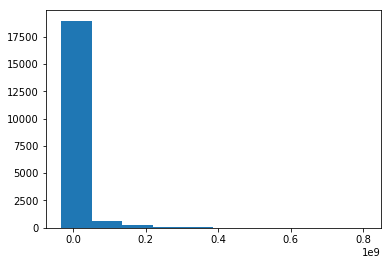

In [43]:
plt.hist(hold)

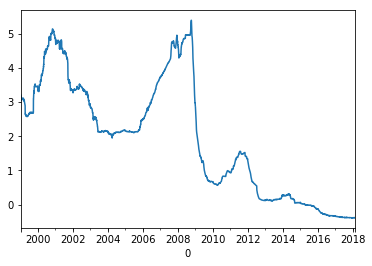

In [44]:
erb.set_index(0)[1].plot()

## Question 4

## Answer:
### The interest rates model depends on the estimation of the long-run interest rate. The Vasicek model permits the existence of negative interest rates, which we could also observe in the models. We could run some market condition based scenarios to evalueate the market risk in different conditions which might better fit the interest rate movements.

.


